In [3]:
import logging
from dataclasses import asdict, dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pprint import pformat
from copy import copy
import torch
import cv2
from contextlib import nullcontext
import numpy as np
from itertools import accumulate
#import roboticstoolbox as rtb

# from safetensors.torch import load_file, save_file
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robot_devices.control_configs import (
    ControlPipelineConfig,
    EvalControlConfig,
)
from lerobot.common.utils.utils import init_logging, get_safe_torch_device
from lerobot.configs import parser

def predict_action(observation, policy, device, use_amp):
    observation = copy(observation)
    with (
        torch.inference_mode(),
        torch.autocast(device_type=device.type) if device.type == "cuda" and use_amp else nullcontext(),
    ):
        # Convert to pytorch format: channel first and float32 in [0,1] with batch dimension
        for name in observation:
            if "image" in name:
                observation[name] = observation[name].type(torch.float32) / 255
                observation[name] = observation[name].permute(2, 0, 1).contiguous()
            observation[name] = observation[name].unsqueeze(0)
            observation[name] = observation[name].to(device)

        # Compute the next action with the policy
        # based on the current observation
        action = policy.select_action(observation)

        # Remove batch dimensifrom dataclasses import asdict, dataclasson
        action = action.squeeze(0)

        # Move to cpu, if not already the case
        action = action.to("cpu")

    return action
def get_episode_data_index(
    episode_dicts: dict[dict], episodes: list[int] | None = None
) -> dict[str, torch.Tensor]:
    episode_lengths = {ep_idx: ep_dict["length"] for ep_idx, ep_dict in episode_dicts.items()}
    if episodes is not None:
        episode_lengths = {ep_idx: episode_lengths[ep_idx] for ep_idx in episodes}

    cumulative_lengths = list(accumulate(episode_lengths.values()))
    return {
        "from": torch.LongTensor([0] + cumulative_lengths[:-1]),
        "to": torch.LongTensor(cumulative_lengths),
    }

# Forward kinematics function
def forward_kinematics(joint_angles,d,a,alpha):
    T = np.eye(4)
    #joint_angles[0] *= -1
    joint_angles_rad = np.radians(joint_angles)
    joint_angles_rad[1] -= 0.136
    joint_angles_rad[2] += 0.162
    joint_angles_rad[3] -= np.pi/2
    joint_angles_rad[4] *= -1 
    for i in range(5):
        theta = joint_angles_rad[i]
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha[i]), np.sin(alpha[i])
        Ti = np.array([
            [ct, -st * ca, st * sa, a[i] * ct],
            [st, ct * ca, -ct * sa, a[i] * st],
            [0, sa, ca, d[i]],
            [0, 0, 0, 1]
        ])
        T = T@Ti # Multiply transformation matrices

    yaw = np.degrees(np.arctan2(T[1, 0], T[0, 0]))
    return T[:3, 3],yaw#theta_tilt  # Extract position (x, y, z)

def compute_r2(q_d, q_a):
    mean_qd = np.mean(q_d)  # Mean of desired trajectory per joint
    sse = np.sum((q_d - q_a) ** 2)  # Sum of squared errors
    sst = np.sum((q_d - mean_qd) ** 2)  # Total variance
    r2 = 1 - (sse / sst)
    return r2

colors = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#984ea3",  # Purple
    "#ff7f00",  # Orange
    "#a65628",  # Brown
    "#66c2a5",  # Teal
    "#999999",  # Gray
    "#f781bf",  # Pink
    "#fc8d62",  # Coral
    "#8da0cb",  # Lavender
    "#e78ac3",  # Pinkish Purple
    "#a6d854",  # Lime Green
    "#ffd92f",  # Bright Yellow
    "#e5c494",  # Light Brown
    "#b3b3b3",  # Light Gray
    "#1b9e77",  # Dark Teal
    "#d95f02",  # Dark Orange
    "#7570b3",  # Indigo
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#e6ab02",  # Mustard
    "#a6761d",  # Golden Brown
    "#666666",  # Dark Gray
    "#b9db23",  # Yellow
    ]
    
d = [0.0563, 0.0, 0.0, 0.0, 0.05815]
a = [0.0, 0.10935, 0.10051, 0.0, 0.0]
alpha = [np.pi/2, np.pi, 0, -np.pi/2, 0]

## E8 Plots ##

### Dataset plot ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_27064\1231735555.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_27064\1231735555.py:75: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[-0.076, 0.1201, 4.9085]
[-0.0373, 0.1199, 4.3924]
[-0.0012, 0.1198, 3.5846]
[0.0374, 0.1211, 0.4634]
[0.073, 0.1217, 0.0573]


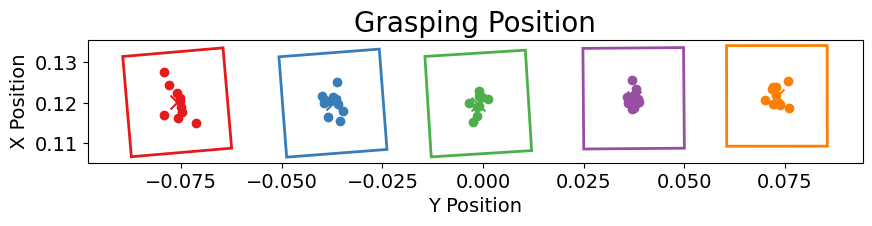

In [ ]:

repo_id="nduque/robustness_e8_5"



dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
obs_grasp = np.array(obs_grasp)

box_pos_avg_e8 = np.array([[-0.0844, 0.1179, 4.2366],[-0.0432, 0.1194, 5.4916],[-0.0092, 0.1179, 6.4004],[0.0291, 0.1177, 2.7933],[0.0658, 0.1165, 1.3591]])
box_pos_avg_e8_5 = np.array([[-0.076, 0.1201, 4.9085],[-0.0373, 0.1199, 4.3924],[-0.0012, 0.1198, 3.5846],[0.0374, 0.1211, 0.4634],[0.073, 0.1217, 0.0573]])

box_avg = box_pos_avg_e8_5

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_y, avg_x, avg_yaw])
    print([avg_y, avg_x, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,1]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,0]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[0]-0.0125,box_pos[1]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=2)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Y Position", fontsize=14)
axs.set_ylabel("X Position", fontsize=14)
axs.set_title("Grasping Position", fontsize=20)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=14)
#axs.set_xlim(-0.1,0.1)


### Evaluation plots ###

In [ ]:
repos = ["nduque/eval_robustness_e8_no3_3_80k",
         "nduque/eval_robustness_e8_no3_3_100k_2",
         "nduque/eval_robustness_e8_no3_3_120k",
         "nduque/eval_robustness_e8_no3_3_140k",
         "nduque/eval_robustness_e8_no3_3_160k",
         "nduque/eval_robustness_e8_no3_3_180k",
         "nduque/eval_robustness_e8_no3_3_200k",
         "nduque/eval_robustness_e8_no3_3_220k",
         "nduque/eval_robustness_e8_no3_3_240k"]